In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pprint import pprint

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import os
import torch
import numpy as np

Распределите в команде гпу, задайте свой номер.

In [4]:
! nvidia-smi

Sun Mar 21 08:15:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   48C    P0    37W / 300W |      5MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

In [5]:
# Set proper device for computations,
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
    
print(f'dtype: {dtype}, device: {device}, cuda_device_id {cuda_device_id}')

dtype: torch.float32, device: cuda:0, cuda_device_id 0


Импортируем полезную либу `attrdict`. Чем она хороша: позволяет обращаться к элементам словаря, как к его атрибутам

In [6]:
from attrdict import AttrDict

# Работа с аудио и текстом

В распознавании речи нейронная сеть обучается на парах аудио+текст.

Давайте научимся открывать аудиофайлы и подготавливать их для работы с нейронной сетью.



На лекциях мы обсуждали, что аудио может быть записано с разной частотой дискретизации (sample rate), но для обучения нейронной сети обычно все аудио приводят к одной частоте дискретизации. (В этом проекте мы будем использовать sample rate 8000).

Так же аудио может быть одноканальным или многоканальным. Проблема с многоканальным аудио может быть в том, что речь в двух каналах может звучать одновременно, такие аудио надо разделять на 2 дорожки. В нашем же случае данные подобраны таким образом, что такой ситуации не возникет, поэтому несколько каналов можно просто усреднить.


Будем использовать библиотеку `torchaudio` [docs](https://pytorch.org/audio/).

Реализуйте функцию `open_audio`, которая открывает аудио (искать [тут](https://pytorch.org/audio/stable/torchaudio.html)), усредняет аудио по всем каналам (это можно сделать обычным усреднением) и приводит к необходимой частоте дискретизации (искать [тут](https://pytorch.org/audio/stable/transforms.html)).

In [7]:
import torchaudio

In [18]:
! ls test_files/

spectrogram.npy  test_dataset.txt	   test_open_audio.npy
test_audio.mp3	 test_open_audio16000.npy
test_audio.opus  test_open_audio2.npy


In [32]:
def open_audio(audio_path, desired_sample_rate, effects=None):
    
    """ Open and resample audio, average across channels
        Inputs:

            audio_path: str, path to audio
            desired_sample_rate: int, the sampling rate to which we would like to convert the audio
        Returns:
            audio: 1D tensor with shape (num_timesteps)
            audio_len: int, len of audio
    """
    ### write your code here ###
    if effects is None:
        audio_data, orig_sample_rate = torchaudio.load(audio_path, channels_first=True)
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=desired_sample_rate)
        audio_data = resampler(audio_data)
    else:
        # Sampling method is inconsistent with torchaudio.transforms.Resample
        audio_data, _ = torchaudio.sox_effects.apply_effects_file(
            audio_path, effects=[*effects, ['rate', str(desired_sample_rate)]], channels_first=True
        )
    
    audio_data = torch.mean(audio_data, axis=0)
    return audio_data, audio_data.shape[0]

Запустите тесты, чтобы проверить себя.
<img src="images/tests_are_all_we_need.png" width="400" height="600">


**Перед каждым запуском тестов не забывайте сохранять ноутбук.**

In [33]:
! pytest tests/test_open_audio.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 2 items                                                              

tests/test_open_audio.py ..                                              [100%]

============================== 2 passed in 1.80s ===============================


Теперь давайте откроем аудио, и послушаем, что у нас получилось.

In [34]:
from IPython.display import Audio

In [35]:
sample_rate = 8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 104740 characters

Так же послушать аудио можно через путь к аудио файлу.

Можно заметить, что звучание немного поменялось. Это произошло из-за того, что мы поменяли оригинальный sample rate 48000Hz на 8000Hz.

In [36]:
Audio('test_files/test_audio.mp3')

limit_output extension: Maximum message size of 10000 exceeded with 52774 characters

Speech2text  —  это не только speech, но и text, поэтому теперь давайте поговорим о предобработке текста. 

Первым шагом необходимо привести текст к нижнему регистру и удалить пунктуацию. Если на этом этапе в тексте содержатся символы кроме русского алфавита и пробела (например, цифры), то такие примеры лучше вообще убрать из обучающей выборки (если просто убрать символ из строки, то может нарушиться соответствие аудио-текст).

В размеченных данных для обучения и валидации уже произедена очистка и удаление ненужных символов, поэтому нам надо только извлечь токены из текста.

В качестве токенов для обучения нейронной сети будем использовать буквы русского алфавита и пробел. Так же, как было сказано в лекциях, нам потребуется специальный символ `<blank>` для построения выравниваний.

In [37]:
alphabet = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к',
            'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц',
            'ч', 'ш', 'щ', 'ь', 'ы', 'ъ', 'э', 'ю', 'я',
            ' ', '<blank>']

Но, естественно, в таком виде передавать буквы в нейронную сеть мы не можем — их нужно закодировать в числа. Для этого будем использовать уже готовую функцию Vocab.

Обратите внимание, что Vocab добавляет дополнительный токен `<unk>`, ответственный за все символы, которых нет в словаре.

In [38]:
from vocabulary import Vocab
vocab = Vocab(alphabet)

The `unk_token` '<unk>' wasn't found in the tokens. Adding the `unk_token` to the end of the Vocab.


Попрактикуйтесь с Vocab. Для того, чтобы понять все возможности Vocab можно заглянуть в код vocabulary.py и почитать докстринги.

* переведите "привет" в индексы
* переведите [11, 0, 11, 33, 4, 5, 12, 0] в текст
* что будет если перевести в индексы слово "hi"?
* а [44, 5] в текст?


In [39]:
vocab.lookup_indices('привет')

[16, 17, 9, 2, 5, 19]

In [40]:
vocab.lookup_tokens([11, 0, 11, 33, 4, 5, 12, 0])

['к', 'а', 'к', ' ', 'д', 'е', 'л', 'а']

In [41]:
vocab.lookup_indices('hi')

[35, 35]

In [42]:
try:
    vocab.lookup_indices([45, 5])
except Exception as ex:
    print(ex)

lookup_indices() Expected a value of type 'List[str]' for argument '_1' but instead found type 'list'.
Position: 1
Value: [45, 5]
Declaration: lookup_indices(__torch__.torch.classes.torchtext.Vocab _0, str[] _1) -> (int[] _0)
Cast error details: Unable to cast Python instance to C++ type (compile in debug mode for details)


Какие еще у Vocab возможности?

Если в процессе исследования вы изменили текущий vocab (путем добавления нового токена, например), не забудьте вернуть vocab к начальному состоянию  `vocab = Vocab(alphabet)`

Давайте извлечем из Vocab и сохраним в переменные два важных значения - длину алфавита и значения индекса `<blank>`.
    
Эти значения нам еще много раз пригодятся.

In [43]:
def get_num_tokens(vocab):
    ### write your code here ###
    num_tokens = len(vocab.tokens2indices())
    return num_tokens

def get_blank_index(vocab):
    ### write your code here ###
    blank_index = vocab['<blank>']
    return blank_index

In [44]:
! pytest tests/test_num_tokens.py
! pytest tests/test_blank_index.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_num_tokens.py .                                               [100%]

============================== 1 passed in 1.73s ===============================
Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_blank_index.py .                                              [100%]

============================== 1 passed in 1.73s ===============================


In [45]:
num_tokens = get_num_tokens(vocab) 
blank_index = get_blank_index(vocab)

# Подготовка датасета

Обучать нейронную сеть мы будем на подготовленном датасете. Для удобства мы сгруппировали обучающие и валидационные данные в текстовые файлы, где в каждой строке через запятую указан путь к файлу, соответствующий текст, длина аудио (в секундах).


Давайте реализуем функцию AudioDataset, которая подготавливает текст и аудио для каждого элемента датастета.


На этих данных мы будем обучать модель с помощью ctc лосса, а мы уже знаем, что для обучения с ctc аудио лучше отсортировать по длине - так модели будет проще обучиться.

Изучить документацию по Dataset и DataLoader (пригодится далее) можно найти [тут](https://pytorch.org/docs/stable/data.html).

In [46]:
import pandas as pd

In [63]:
 class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, vocab, sample_rate=8000, audio_tranforms=None):
        self.vocab = vocab
        self.sample_rate = sample_rate
        self.audio_tranforms = audio_tranforms
        
        data = pd.read_csv(dataset_path, header=None, names=['audio_path', 'text', 'duration'])
        data['duration'] = data['duration'].astype(float)
        self.data = data.sort_values(by='duration')
        
        self.idx_to_text_len = dict()
        self.idx_to_audio_len = dict()
#         for idx in range(self.data.shape[0]):
#             self.idx_to_text_len[idx] = len(self.data.iloc[idx]['text'])
#             self.idx_to_audio_len[idx] = self.data.iloc[idx]['duration']
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        audio_path = self.data.audio_path[idx]
        text = self.data.text[idx]

        ### write your code here ###
        text_len = len(text)
        tokens = torch.tensor(self.vocab.lookup_indices(text))
        audio, audio_len = open_audio(audio_path, self.sample_rate, effects=self.audio_tranforms.sample())
        
        return {"audio":  audio,  # torch tensor, (num_timesteps)
                "audio_len": audio_len, # int
                "text": text, # str
                "text_len": text_len, # int
                'tokens': tokens, # torch tensor, (text_len)
               }
    
class AudioTransform(torch.nn.Module):
    def __init__(self, effects=None):
        super().__init__()
        self.effects = [] if effects is None else effects
        
    def sample(self):
        sampled_effects = []
        for effect_name, lower, upper in self.effects:
            magnitude = np.random.uniform(low=lower, high=upper)
            sampled_effects.append([effect_name, str(magnitude)])
            
        return sampled_effects

In [64]:
AudioTransform([
    ['test', 0, 1]
]).sample()

[['test', '0.4146022632518763']]

In [65]:
ds = AudioDataset(
    train_dataset_path, vocab,
    audio_tranforms=AudioTransform([
        
        ['delay', 0.0, 1.0]
    ])
)

In [80]:
ds[0]

{'audio': tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.0004,  0.0005, -0.0009]),
 'audio_len': 13901,
 'text': 'один',
 'text_len': 4,
 'tokens': tensor([15,  4,  9, 14])}

In [58]:
print(torchaudio.sox_effects.effect_names())

['allpass', 'band', 'bandpass', 'bandreject', 'bass', 'bend', 'biquad', 'chorus', 'channels', 'compand', 'contrast', 'dcshift', 'deemph', 'delay', 'dither', 'divide', 'downsample', 'earwax', 'echo', 'echos', 'equalizer', 'fade', 'fir', 'firfit', 'flanger', 'gain', 'highpass', 'hilbert', 'loudness', 'lowpass', 'mcompand', 'norm', 'oops', 'overdrive', 'pad', 'phaser', 'pitch', 'rate', 'remix', 'repeat', 'reverb', 'reverse', 'riaa', 'silence', 'sinc', 'speed', 'stat', 'stats', 'stretch', 'swap', 'synth', 'tempo', 'treble', 'tremolo', 'trim', 'upsample', 'vad', 'vol']


In [29]:
! pytest tests/test_dataset.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 2 items                                                              

tests/test_dataset.py ..                                                 [100%]

============================== 2 passed in 1.89s ===============================


Давайте посмотрим, как будут выглядеть элементы полученного датасета.

In [59]:
train_dataset_path = '/home/e.chuykova/data/train.txt'
test_dataset_path = '/home/e.chuykova/data/test.txt'
val_dataset_path = '/home/e.chuykova/data/val.txt'

train_dataset = AudioDataset(train_dataset_path, vocab)
test_dataset = AudioDataset(test_dataset_path, vocab)
val_dataset = AudioDataset(val_dataset_path,vocab)

In [25]:
import matplotlib.pyplot as plt

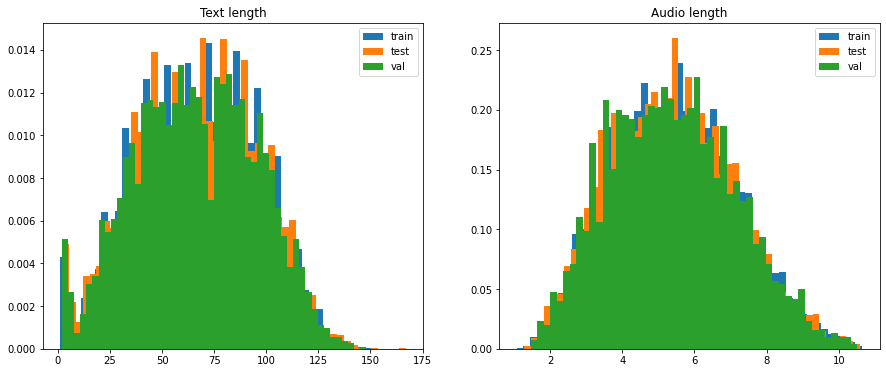

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
_ = axes[0].hist(train_dataset.idx_to_text_len.values(), bins=50, label='train', density=True)
_ = axes[0].hist(test_dataset.idx_to_text_len.values(), bins=50, label='test', density=True)
_ = axes[0].hist(val_dataset.idx_to_text_len.values(), bins=50, label='val', density=True)

_ = axes[1].hist(train_dataset.idx_to_audio_len.values(), bins=50, label='train', density=True)
_ = axes[1].hist(test_dataset.idx_to_audio_len.values(), bins=50, label='test', density=True)
_ = axes[1].hist(val_dataset.idx_to_audio_len.values(), bins=50, label='val', density=True)

axes[0].set_title('Text length')
axes[1].set_title('Audio length')

axes[0].legend()
axes[1].legend()

plt.show()

In [32]:
for i, element in enumerate(train_dataset):
    print(f'element number: {i}')
    pprint(element)
    print()
    if i > 1:
        break

element number: 0
{'audio': tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.0005, -0.0008, -0.0006]),
 'audio_len': 8360,
 'text': 'один',
 'text_len': 4,
 'tokens': tensor([15,  4,  9, 14])}

element number: 1
{'audio': tensor([-1.3758e-09, -2.2855e-09, -1.3640e-09,  ..., -2.1114e-04,
        -4.1249e-04, -2.6402e-04]),
 'audio_len': 8640,
 'text': 'ноль',
 'text_len': 4,
 'tokens': tensor([14, 15, 12, 27])}

element number: 2
{'audio': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0068, 0.0080, 0.0038]),
 'audio_len': 8987,
 'text': 'два',
 'text_len': 3,
 'tokens': tensor([4, 2, 0])}



Чтобы эффективно обучать нейронную сеть, необходимо подавать в нее данные батчами. В этом нам поможет функция `torch.utils.data.DataLoader`. 

Обратите внимание, что некоторые данные в датасете разной длины (например, `audio`), для формирования батча из таких данных  необходимо использовать паддинг. Для этого можно реализовать фукцию `collate_fn`. Подробнее про то, как именно использовать `collate_fn` можно почитатать в доках к `torch.utils.data.DataLoader`.

In [33]:
from torch.nn.utils.rnn import pad_sequence

In [34]:
def collate_fn(batch):
    """ 
        Inputs:
            batch: list of elements with length=batch_ize
        Returns:
            dict
    """
    ### write your code here ###
    audios = torch.nn.utils.rnn.pad_sequence(
        [obj['audio'] for obj in batch], batch_first=True, padding_value=0.0
    )
    audio_lens = torch.tensor([obj['audio'].shape[0] for obj in batch])
    
    texts = [obj['text'] for obj in batch]
    text_lens = torch.tensor([len(obj['text']) for obj in batch])
    tokens = torch.nn.utils.rnn.pad_sequence(
        [obj['tokens'] for obj in batch], batch_first=True, padding_value=0.0
    )
    
    return {'audios': audios, # torch tensor, (batch_size, max_num_timesteps)
            'audio_lens': audio_lens, # torch tensor, (batch_size)
            'texts': texts,  # list, len=(batch_size)
            "text_lens": text_lens, # torch tensor, (batch_size)
            'tokens': tokens,  # torch tensor, (batch_size, max_text_len)
           }

In [35]:
! pytest tests/test_collate_fn.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_collate_fn.py .                                               [100%]

============================== 1 passed in 1.79s ===============================


In [36]:
batch_size = 90
num_workers = 8

При создании DataLoader не забудьте использовать параметры `batch_size`, `num_workers`.

Так же в DataLoader есть параметр `shuffle`, который используется для перемешивания данных. Сейчас наши аудио отсортированы по длине, т.е. длины аудио внутри одного батча максимально близки друг другу - и это самый эффективный способ формировать батчи в распознавании речи. Если включить shuffle=True, то короткие аудио могут попасть в один батч с длинными, средний размер батча увеличится, это будет менее эффективно. Поэтому необходимо **перемешивать сформированные батчи**, а не элементы датасета.
    
Реализовать перемешивание батчей в PyTorch - это не самая простая задача, поэтому советую сейчас пропустить этот шаг.

In [37]:
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler, RandomSampler

In [38]:
class AudioDatasetSampler:
    def __init__(self, dataset, batch_size):
        self.epoch = 0
        self.dataset = dataset
        self.batch_size = batch_size

        # Assume that data in dataset is sorted w.r. to duration
        self.batches = list(BatchSampler(SequentialSampler(self.dataset), batch_size=self.batch_size, drop_last=False))
    
    def __iter__(self):
        if self.epoch == 0:
            for batch_idx in SequentialSampler(self.batches):
                for idx in self.batches[batch_idx]:
                    yield idx
        else:
            for batch_idx in RandomSampler(self.batches):
                for idx in self.batches[batch_idx]:
                    yield idx
        self.epoch += 1
        
    def __len__(self):
        return len(self.dataset)

In [39]:
# YOUR CODE
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=AudioDatasetSampler(train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
# YOUR CODE
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

Давайте посмотрим, что у нас хранится в даталоадере. Обратите внимание, что из-за `batch_size=90` выведется достаточно много значений. Можно уменьшить `batch_size`, чтобы посмотреть на выход, но обучать сеть лучше с `batch_size=90`.

In [40]:
for i, element in enumerate(train_dataloader):
    print(f'element number: {i}')
    pprint(element)
    print()
    if i > 0:
        break

element number: 0
{'audio_lens': tensor([ 8360,  8640,  8987,  9196,  9196,  9405,  9405,  9600,  9823, 10032,
        10176, 10176, 10368, 10449, 10560, 10560, 10560, 10560, 10560, 10560,
        10560, 10560, 10560, 10560, 10658, 10752, 10752, 11136, 11136, 11136,
        11136, 11285, 11328, 11328, 11520, 11520, 11520, 11520, 11520, 11520,
        11520, 11520, 11712, 11712, 11712, 11712, 11703, 11904, 11904, 11904,
        12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096,
        12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096,
        12096, 12288, 12288, 12288, 12288, 12288, 12330, 12480, 12480, 12480,
        12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480]),
 'audios': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3758e-09, -2.2855e-09, -1.3640e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00

limit_output extension: Maximum message size of 10000 exceeded with 10965 characters

# Акустические фичи

Как мы обсуждали на лекциях, есть разные способы построить аудио фичи. Мы будем использовать log mel spectrogram.


In [41]:
def compute_log_mel_spectrogram(audio, sequence_lengths,
                            sample_rate=8000,
                            window_size=0.02,
                            window_step=0.01,
                            f_min=20,
                            f_max=3800,
                            n_mels=64,
                            window_fn=torch.hamming_window,
                            power=1.0,
                            eps=1e-6
                            ):
    """ Compute log-mel spectrogram.
        Input shape:
            audio: 3D tensor with shape (batch_size, num_timesteps)
            sequence_lengths: 1D tensor with shape (batch_size)
        Returns:
            4D tensor with shape (batch_size, n_mels, new_num_timesteps)
            1D tensor with shape (batch_size)
    """

    win_length = int(window_size * sample_rate)
    hop_length = int(window_step * sample_rate)
    
    ### write your code here ###
    mel_transformer = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, win_length=win_length, hop_length=hop_length, n_fft=win_length,
        f_min=f_min, f_max=f_max, pad=0, n_mels=n_mels, power=power, window_fn=window_fn
    ).to(device=audio.device)

    log_mel_spectrogram = torch.log(mel_transformer(audio) + eps)
    seq_len = ((sequence_lengths + 2 * hop_length - win_length) // hop_length + 1).to(dtype=torch.long)    
    
    return log_mel_spectrogram, seq_len

In [42]:
batch = next(iter(train_dataloader))
log_mel_spectrogram, sequence_lengths = compute_log_mel_spectrogram(batch['audios'], batch['audio_lens'])
print(log_mel_spectrogram.shape, sequence_lengths.shape)

torch.Size([90, 64, 157]) torch.Size([90])


In [43]:
! pytest tests/test_compute_log_mel_spectrogram.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_compute_log_mel_spectrogram.py .                              [100%]

============================== 1 passed in 1.74s ===============================


Давайте посмотрим, как выглядит log-mel спектрограмма.

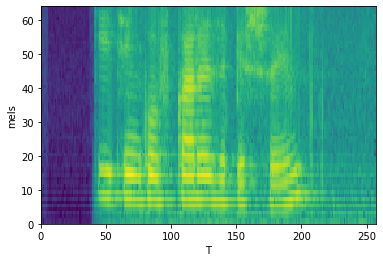

limit_output extension: Maximum message size of 10000 exceeded with 54904 characters

In [44]:
audio, audio_len = open_audio('test_files/test_audio.opus', 8000)
spectrogram, new_len = compute_log_mel_spectrogram(audio, torch.tensor(audio_len))
plt.pcolormesh(spectrogram)
plt.xlabel('T')
plt.ylabel('mels')
plt.show()
Audio(data=audio.numpy(), rate=sample_rate)

# Нейронная сеть

Мы подготовили все данные, теперь можно заняться реализацией нейронной сети. Будем реализовывать архитектуру [Deepspeech 2](https://arxiv.org/pdf/1512.02595.pdf) в немного упрощенном виде.


<img src="images/cat_reproduction.jpg" width="400" height="400">


Вот так будет выглядеть архитектура сети:


<img src="images/deepspeech.jpg" width="200" height="150">

In [45]:
import torch.nn as nn
import torch.nn.functional as F

In [46]:
def _calculate_fan(dimentions, conv_params, axis):
    stride = conv_params.get('stride', [1, 1])[axis]
    padding = conv_params.get('padding', [0, 0])[axis]
    kernel_size = conv_params.get('kernel_size')[axis]
    dillation = conv_params.get('dillation', [1, 1])[axis]
    
    return torch.floor((dimentions + 2 * padding - dillation * (kernel_size - 1) - 1) / stride + 1).to(dtype=torch.long)
    
class Model(nn.Module):
    def __init__(self, num_mel_bins, hidden_size, num_layers, num_tokens):
        super(Model, self).__init__()
        
        self.num_tokens = num_tokens
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1
        
        self.num_mel_bins = num_mel_bins
        
        conv1_params = AttrDict(
            {
                "in_channels": 1,
                "out_channels": 32,
                "kernel_size": [21, 11],
                "stride": [1, 1] 
            })                             
        conv2_params = AttrDict(
            {
                "in_channels": conv1_params['out_channels'],
                "out_channels": 64,
                "kernel_size": [11, 11],
                "stride": [1, 3]
            }
        )
        
        self.conv1_params = conv1_params
        self.conv2_params = conv2_params
        
        # [batch_size x 1 X num_mel_bins x time] -> [batch_size x conv2.out_channels x fan_num_mel_bins x fan_time]
        self.conv = nn.Sequential(
            ### write your code here ###
        
            # CONV 1
            torch.nn.Conv2d(**self.conv1_params, bias=False),
            # BATCH NORM 1
            torch.nn.BatchNorm2d(num_features=self.conv1_params['out_channels'], momentum=0.9),
            # RELU
            torch.nn.ReLU(inplace=True),
            
            # CONV 2
            torch.nn.Conv2d(**self.conv2_params, bias=False),
            # BATCH NORM 2
            torch.nn.BatchNorm2d(num_features=self.conv2_params['out_channels'], momentum=0.9),
            # RELU
            torch.nn.ReLU(inplace=True),            
        )
        
        # YOUR CODE
        fan_num_mel_bins = _calculate_fan(
            _calculate_fan(torch.tensor(num_mel_bins), conv1_params, axis=0), 
            conv2_params, axis=0
        ).item()
        rnn_input_size = self.conv2_params['out_channels'] * fan_num_mel_bins

        # 4 слоя бидир lstm
        # YOUR CODE
        # [batch_size x fan_time x rnn_input_size] -> [batch_size x fan_time x num_directions * hidden_size], (h_n, c_n)
        self.lstm = torch.nn.LSTM(
            input_size=rnn_input_size, hidden_size=hidden_size, num_layers=self.num_layers,
            bias=True, batch_first=True, bidirectional=self.bidirectional
        )
        
         # YOUR CODE
        # [batch_size x num_directions * hidden_size] -> [batch_size, num_tokens]
        self.output_layer = torch.nn.Linear(self.num_directions * self.hidden_size, self.num_tokens)
    
    def forward(self, inputs, seq_lens, state=None):
        """
            Input shape:
                audio: 3D tensor with shape (batch_size, num_mel_bins, num_timesteps)
                sequence_lengths: 1D tensor with shape (batch_size)
            Returns:
                3D tensor with shape (new_num_timesteps, batch_size, alphabet_len)
                1D tensor with shape (batch_size)
            """
        
        outputs = inputs.unsqueeze(1) # conv2d input should be four-dimensional
        
        ### write your code here ###
        seq_lens = _calculate_fan(_calculate_fan(seq_lens, self.conv1_params, axis=1), self.conv2_params, axis=1)
        
        outputs = self.conv(outputs)

        outputs = self.transpose_and_reshape(outputs)
        outputs, (h_n, c_n) = self.lstm(outputs)

        outputs = self.output_layer(outputs)
        outputs = torch.transpose(outputs, 0, 1)
        outputs = F.log_softmax(outputs, dim=-1)
        
        return outputs, seq_lens

    @staticmethod
    def transpose_and_reshape(inputs):
    
        """ This function will be very useful for converting the output of a convolutional layer 
            to the input of a lstm layer
            
            Input shape:
                inputs: 4D tensor with shape (batch_size, num_filters, num_features, num_timesteps)
            Returns:
                3D tensor with shape (batch_size, num_timesteps, new_num_features)
            """
            
        sizes = inputs.size()
                
        # reshape # YOUR CODE
        # (batch_size, num_filters * num_features, num_timesteps)
        outputs = inputs.reshape(inputs.shape[0], inputs.shape[1] * inputs.shape[2], inputs.shape[3])
        # transpose # YOUR CODE
        # (batch_size, num_timesteps, new_num_features)
        outputs = torch.transpose(outputs, 1, 2)
        return outputs
           
    @staticmethod
    def get_new_seq_lens(seq_lens, conv1_kernel_size, conv1_stride, conv2_kernel_size, conv2_stride):
    
        """ Compute sequence_lengths after convolutions
            """
            
        ### write your code here ###
        seq_lens = _calculate_fan(seq_lens, {'kernel_size': [conv1_kernel_size], 'stride': [conv1_stride]}, axis=0)
        seq_lens = _calculate_fan(seq_lens, {'kernel_size': [conv2_kernel_size], 'stride': [conv2_stride]}, axis=0)
        return seq_lens

In [47]:
num_tokens = len(vocab.tokens2indices()) - 1
num_mel_bins = 64
hidden_size= 512
num_layers = 4

In [48]:
model = Model(num_mel_bins=num_mel_bins,
              hidden_size=hidden_size,
              num_layers=num_layers,
              num_tokens=num_tokens)

In [49]:
! pytest tests/test_model.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 5 items                                                              

tests/test_model.py .....                                                [100%]

============================== 5 passed in 2.78s ===============================


Инициализируем модель из чекпоинта, чтобы она обучилась быстрее.

In [50]:
def load_from_ckpt(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

In [51]:
load_from_ckpt(model, '/home/e.chuykova/data/ckpt.pt')

Тест, чтобы проверить, что код модели корректно написан, модель правильно восстановилась из чекпоинта

In [52]:
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
output = model(*compute_log_mel_spectrogram(torch.unsqueeze(audio, 0), torch.unsqueeze(torch.tensor([audio_len]), 0)))
assert torch.isclose(output[0][0][0][0], torch.tensor(-3.53916406))
assert torch.isclose(output[0][15][0][30], torch.tensor(-3.605963468))

Отправим модель на гпу.

<img src="images/cuda_is_important.jpg" width="400" height="400">


In [53]:
model.to(device=device)

Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=[21, 11], stride=[1, 1], bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=[11, 11], stride=[1, 3], bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (lstm): LSTM(2176, 512, num_layers=4, batch_first=True, bidirectional=True)
  (output_layer): Linear(in_features=1024, out_features=35, bias=True)
)

# Обучаем модельку

In [54]:
from time import time
from tqdm import tqdm_notebook as tqdm
import os

Давайте напишем несколько вспомогательных функций, которые будут нам нужны для обучения модели.

Для начала займемся метриками. Основная метрика - wer (word error rate).

Тут поможет библиотека `editdistance`.

In [55]:
import editdistance

In [56]:
import regex

In [57]:
def calc_wer(predicted_text, gt_text):
    """ Compute wer.
        Inputs:
            predicted_text: str
            gt_text: str
        Returns:
            wer: int
    """
    ### write your code here ###
    words_split_pattern = regex.compile(r'\b\w+\b')
    
    gt_words = regex.findall(words_split_pattern, gt_text)
    predicted_words = regex.findall(words_split_pattern, predicted_text)
    
    if len(gt_words) == len(predicted_words) == 0:
        return 0.0
    if len(gt_words) == 0:
        return 1.0
    wer = editdistance.eval(predicted_words, gt_words) / len(gt_words)
    return wer


def calc_wer_for_batch(list_of_predicted_text, list_of_gt_text):
    """ Compute mean wer for batch.
            Inputs:
                list_of_predicted_text: list
                list_of_gt_text: list
            Returns:int
            
    """
    
    ### write your code here ###
    mean_wer = np.mean([calc_wer(_, __) for _, __ in zip(list_of_predicted_text, list_of_gt_text)])
    return mean_wer

In [58]:
! pytest tests/test_compute_wer.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 7 items                                                              

tests/test_compute_wer.py .......                                        [100%]

============================== 7 passed in 1.74s ===============================


Давайте реализуем greedy decoding. 

Сначала научимся получать greedy trn из выравниваний. Можно использовать `itertools`.

Не забудьте выкинуть лишние пробелы в начале и конце полученного текста!

In [59]:
import itertools

In [60]:
def decode(alignment):
    """ Get text from alignment.
        Inputs:
            alignment: str
        Returns:
            text: srt
    """
    ### write your code here ###
    alignment = regex.sub(r'(\p{L})\1+', r'\1', alignment)
    alignment = alignment.replace('<blank>', '')
    alignment = regex.sub(' +', ' ', alignment)
    text = alignment.strip()
    return text

In [61]:
! pytest tests/test_decode.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 4 items                                                              

tests/test_decode.py ....                                                [100%]

============================== 4 passed in 1.73s ===============================


Получим greedy text из выхода акустической модели (logprobs).

In [62]:
def greedy_decoder(logprobs, logprobs_lens, vocab):
    predictions = []
    
    tokens = torch.argmax(logprobs, dim=-1)
    for idx in range(logprobs.shape[1]):        
        alligmnet_tokens = vocab.lookup_tokens(tokens[:, idx][:logprobs_lens[idx]].detach().cpu().numpy())
        alligmnet = ''.join(alligmnet_tokens)
        hypo = decode(alligmnet)
        predictions += [[(hypo, 1.0)]]
    
    return predictions

In [63]:
from collections import defaultdict

In [64]:
def beam_search_decode(logprobs, logprobs_lens, vocab, beam_size, cutoff_top_n, cutoff_prob, ext_scoring_func, alpha):
    '''
    logprobs: [num_timesteps, alphabet_len]
    '''
    def _beam_search_decode(
        _logprobs, _logprobs_len, 
        vocab, beam_size, cutoff_top_n, cutoff_prob, ext_scoring_func, alpha
    ):
        assert (cutoff_top_n is None) or (cutoff_prob is None)
        if (cutoff_top_n is None) and (cutoff_prob is None):
            cutoff_prob = 1.0

        hypos = set()
        indices2tokens = vocab.indices2tokens()
        probs_b, probs_nb = defaultdict(float), defaultdict(float)

        hypos.add('')
        probs_b[''], probs_nb[''] = 1.0, 0.0
        for t in range(_logprobs_len):
            hypos_new = set()
            probs_b_new, probs_nb_new = defaultdict(float), defaultdict(float)

            probs_t = torch.exp(_logprobs[t]).detach().cpu()
            decreace_idxs = torch.argsort(-probs_t).detach().cpu().numpy()
            if cutoff_prob is not None:
                cond_idxs = torch.where(torch.cumsum(probs_t[decreace_idxs], dim=0) > cutoff_prob)[0]
                if len(cond_idxs) == 0:
                    cutoff_top_n = len(decreace_idxs)
                else:
                    cutoff_top_n = cond_idxs[0].item()
                if cutoff_top_n == 0:
                    cutoff_top_n = 1

            for l in hypos:
                for c_idx in decreace_idxs[:cutoff_top_n]:
                    c, c_prob = indices2tokens[c_idx], probs_t[c_idx]

                    if c == '<blank>':
                        probs_b_new[l] += c_prob * (probs_b[l] + probs_nb[l])
                    else:
                        l_end = l[-1] if len(l) > 0 else ''
                        l_plus = l + c
                        if c == l_end:
                            probs_nb_new[l] += c_prob * probs_nb[l]
                            probs_nb_new[l_plus] += c_prob * probs_b[l]
                        elif c == ' ':
                            if ext_scoring_func is None:
                                p_W = 1.0
                            else:
                                p_W = ext_scoring_func(l)
                            probs_b_new[l_plus] += np.power(p_W, alpha) * c_prob * (probs_b[l] + probs_nb[l])
                        else:
                            probs_nb_new[l_plus] += c_prob * (probs_b[l] + probs_nb[l])
                        hypos_new.add(l_plus)                                        
                hypos_new.add(l)


            hypos_new = list(
                sorted(hypos_new, key=lambda hypo: probs_b_new[hypo] + probs_nb_new[hypo], reverse=True)
            )[:min(beam_size, len(hypos_new))]

            hypos, probs_b, probs_nb = hypos_new, probs_b_new, probs_nb_new

        return sorted(
            [(hypo, probs_b_new[hypo] + probs_nb_new[hypo]) for hypo in hypos],
            key=lambda key_value: key_value[1], reverse=True
        )
    
    predictions = []
    for idx in range(logprobs.shape[1]):
        hypos =  _beam_search_decode(
            logprobs[:, idx], logprobs_lens[idx],
            vocab=vocab, beam_size=beam_size,
            cutoff_top_n=cutoff_top_n, cutoff_prob=cutoff_prob,
            ext_scoring_func=ext_scoring_func, alpha=alpha
        )
        predictions.append(hypos)

    return predictions

In [65]:
from ctcdecode import CTCBeamDecoder

In [66]:
def fast_beam_search_decode(
    logprobs, logprobs_lens, vocab, beam_size, cutoff_top_n, cutoff_prob, ext_scoring_func, alpha, beta, num_processes
):
    labels = ''.join(vocab.indices2tokens()).replace('<blank>', '_').replace('<unk>', '')
    decoder = CTCBeamDecoder(
        labels=labels, blank_id=blank_index,
        cutoff_top_n=cutoff_top_n, cutoff_prob=cutoff_prob, beam_width=beam_size,
        model_path=ext_scoring_func, alpha=alpha, beta=beta,
        num_processes=num_processes,
        log_probs_input=False
    )
    probs = torch.exp(logprobs)
    beam_results, beam_scores, timesteps, out_lens = decoder.decode(torch.transpose(probs, 0, 1), logprobs_lens)
    beam_probas = torch.exp(-beam_scores)
    
    predictions = []
    for idx in range(beam_results.shape[0]):
        beam = []
        for jdx in range(beam_results.shape[1]):
            hypo = ''.join(vocab.lookup_tokens(beam_results[idx, jdx, :out_lens[idx, jdx]].tolist()))
            hypo_score = beam_probas[idx, jdx]
            beam.append((hypo, hypo_score))
        predictions.append(beam)
        
    return predictions

In [67]:
def get_prediction(logprobs, logprobs_lens, vocab, decoder=greedy_decoder, decoder_kwargs=None):
    """ Compute greedy text from loglikes.
            Input shape:
                logprobs: 3D tensor with shape (num_timesteps, batch_size, alphabet_len)
                logprobs_lens: 1D tensor with shape (batch_size)
            Returns:
                list of texts with len (batch_size)
    """
    if decoder_kwargs is None:
        decoder_kwargs = dict()
        
    predictions = decoder(logprobs=logprobs, logprobs_lens=logprobs_lens, vocab=vocab, **decoder_kwargs)
    predictions = [sorted(hypos, key=lambda key_value: key_value[1], reverse=True)[0][0] for hypos in predictions]

    return predictions

In [119]:
batch = next(iter(val_dataloader))
batch = {
    key: value.to(device=device) if isinstance(value, torch.Tensor) else value for key, value in batch.items()
}

log_mel_spectrogram, seq_lens = compute_log_mel_spectrogram(batch['audios'], batch['audio_lens'])
logprobs, seq_lens = model(log_mel_spectrogram, seq_lens)

In [120]:
print(get_prediction(logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, decoder=greedy_decoder))

['нет', 'нет', 'да', 'пять', 'эй', 'фемь', 'ноль', 'три', 'три', 'эй', 'семь', 'восемь', 'вот так', 'вами', 'ноль', 'три', 'пять', 'девять', 'четыре', 'восемь', 'два', 'четыре', 'вот чта я предлагаю', 'оставь', 'вот так', 'ну и что же', 'пять', 'эй', 'девять', 'ноль', 'ноль', 'ноль', 'пять', 'парки было шумна', 'нольли', 'и точно', 'хоту с вами', 'шесть', 'три', 'и точно', 'эй', 'семь', 'два', 'украйны несключенияе', 'восемь', 'эй', 'ноль', 'ван слово посеол', 'семь', 'вот смотри', 'девять', 'восемь', 'четыре', 'го', 'да', 'позе', 'восемь', 'благодарю вас за внимание', 'семь', 'нет', 'вось есть рецепт', 'и тимур вз дохнул', 'эй', 'показать список', 'вапо прижс крий', 'да', 'босемь', 'четыре', 'девять', 'ти морушл', 'эй', 'три', 'и это тоже факт', 'нет', 'я очень люблю летать', 'акко хорошо', 'не так ли', 'мы непросит за это прощения', 'он вновь не ответил', 'это тревога', 'мы здесь одни', 'лишнего мне не надо', 'этй', 'три', 'три', 'мир праху его', 'он в порядке', 'шесть', 'пять', 'оди

In [121]:
beam_kwargs = {'beam_size': 10, 'cutoff_top_n': 1, 'cutoff_prob': None, 'ext_scoring_func': None, 'alpha': 1.0}

In [122]:
print(get_prediction(
    logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, 
    decoder=beam_search_decode, decoder_kwargs=beam_kwargs
))

['нет', 'нет', 'да', 'пять', 'эй', 'фемь', 'ноль', 'три', 'три', 'эй', 'семь', 'восемь', 'вот  так', 'вами', 'ноль', 'три', 'пять', 'девять', 'четыре', 'восемь', 'два', 'четыре', 'вот чта я предлагаю', 'оставь', 'вот  так', 'ну и что же', 'пять', 'эй', 'девять', 'ноль', 'ноль', 'ноль', 'пять', 'парки  было шумна', 'нольли', 'и  точно', ' хоту  с  вами', 'шесть', 'три', 'и  точно', 'эй', 'семь', 'два', 'украйны  несключенияе', 'восемь', 'эй', 'ноль', 'ван  слово  посеол', 'семь', 'вот  смотри', 'девять', 'восемь', 'четыре', 'го', 'да', 'позе', 'восемь', 'благодарю вас за внимание', 'семь', 'нет', 'вось  есть  рецепт', 'и тимур вз дохнул', 'эй', 'показать список', 'вапо  прижс  крий', 'да', 'босемь', 'четыре', 'девять', 'ти морушл', 'эй', 'три', 'и  это  тоже  факт', 'нет', 'я  очень  люблю  летать', 'акко  хорошо', 'не  так  ли', 'мы  непросит  за это прощения', 'он  вновь  не ответил', 'это  тревога', 'мы  здесь одни', 'лишнего мне  не  надо', 'этй', 'три', 'три', 'мир  праху его', 'он

In [123]:
fast_beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 1, 'cutoff_prob': 1.0, 
    'ext_scoring_func': None, 'alpha': 1.0, 'beta': 0.0, 'num_processes': 16
}

In [124]:
print(get_prediction(
    logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, 
    decoder=fast_beam_search_decode, decoder_kwargs=fast_beam_kwargs
))

['нет', 'нет', '', 'пять', 'эй', 'фемь', 'ноль', 'три', 'три', 'эй', 'семь', 'восемь', 'вот так', 'вами', 'ноль', 'три', 'пять', 'девять', 'четыре', 'восемь', 'два', 'четыре', 'вот чта я предлагаю', 'оставь', 'вот так', 'ну и что же', 'пять', 'эй', 'девять', 'ноль', 'ноль', 'ноль', 'пять', 'парки было шумна', 'нольли', 'и точно', ' хоту с вами', 'шесть', 'три', 'и точно', 'эй', 'семь', 'два', 'украйны несключенияе', 'восемь', 'эй', 'ноль', 'ван слово посеол', 'семь', 'вот смотри', 'девять', 'восемь', 'четыре', '', '', 'позе', 'восемь', 'благодарю вас за внимание', 'семь', 'нет', 'вось есть рецепт', 'и тимур вз дохнул', 'эй', 'показать список', 'вапо прижс крий', '', 'босемь', 'четыре', 'девять', 'ти морушл', 'эй', 'три', 'и это тоже факт', 'нет', 'я очень люблю летать', 'акко хорошо', 'не так ли', 'мы непросит за это прощения', 'он вновь не ответил', 'это тревога', 'мы здесь одни', 'лишнего мне не надо', 'этй', 'три', 'три', 'мир праху его', 'он в порядке', 'шесть', 'пять', 'один']


In [74]:
! pytest tests/test_get_prediction.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_get_prediction.py .                                           [100%]

============================== 1 passed in 1.69s ===============================


В этой функции надо из сырых данных, извлеченных из датасета, получить спектрограмму, прогнать через модель, посчитать средний лосс и wer для батча, list с текстами предсказанных гипотез для батча.

In [75]:
def get_model_results(
    model, audios, audio_lens, tokens, texts, text_lens, 
    vocab, loss_fn, decoder, decoder_kwargs
):
    """ get mean loss, mean wer and prediction list for batch
        Returns:
            loss: int
            wer: int
            prediction: list of str
            
    """
    ### write your code here ###
    log_mel_spectrogram, seq_lens = compute_log_mel_spectrogram(audios, audio_lens)
    logprobs, seq_lens = model(log_mel_spectrogram, seq_lens)
    loss = loss_fn(logprobs, tokens, seq_lens, text_lens)

    with torch.no_grad():
        predictions = get_prediction(logprobs, seq_lens, vocab, decoder=decoder, decoder_kwargs=decoder_kwargs)
        wer = calc_wer_for_batch(predictions, texts)
    
    return loss, wer, predictions

Для удобства будем логировать метрики в [tensorboard](https://pytorch.org/docs/stable/tensorboard.html).

In [76]:
from torch.utils.tensorboard import SummaryWriter

In [77]:
class TensorboardLogger:
    def __init__(self, tensorboard_path):
        self.writer = SummaryWriter(tensorboard_path)

    def log(self, step, loss, wer, mode):
        assert mode in ('train', 'val')
        
        ### write your code here ###
        
        # add loss to tb 
        # add wer to tb 
        self.writer.add_scalar(f'wer/{mode}', wer, global_step=step)
        self.writer.add_scalar(f'loss/{mode}', loss, global_step=step)

    def log_text(self, step, pred_texts, gt_texts, mode):
        
        ### write your code here ###
        
        for pred_text in pred_texts:
            # add pred text to tb 
            self.writer.add_text(f'predict/{mode}', pred_text, global_step=step)
            
        for gt_text in gt_texts:
            # add gt text to tb 
            self.writer.add_text(f'ground truth/{mode}', gt_text, global_step=step)
      
    def close(self):
        self.writer.close()

Теперь можем собрать функции в train loop. 

## Training parameters

In [78]:
def validate(model, dataloader, vocab, loss_fn, decoder, decoder_kwargs):
    loss, wer = 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, total=len(dataloader)):
            batch = {
                key: value.to(device=device) if isinstance(value, torch.Tensor) else value for key, value in batch.items()
            }
            loss_batch, wer_batch, prediction = get_model_results(
                model, batch["audios"], batch["audio_lens"],
                batch["tokens"], batch["texts"], batch["text_lens"], vocab, loss_fn,
                decoder=decoder, decoder_kwargs=decoder_kwargs
            )

            loss += loss_batch.item() * batch['audio_lens'].shape[0]
            wer += wer_batch * batch['audio_lens'].shape[0]

        loss /= len(dataloader.dataset)
        wer /= len(dataloader.dataset)
    return loss, wer

In [133]:
def training(
    model, optimizer, loss_fn, num_epochs, 
    train_dataloader, val_dataloader, log_every_n_batch, model_dir,
    vocab, beam_kwargs
):

    logger = TensorboardLogger(model_dir)

    for epoch in range(num_epochs):
        start_time = time()
        train_loss, train_wer = 0, 0
        
        model.train(True)
        for iteration, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
            batch = {
                key: value.to(device=device) if isinstance(value, torch.Tensor) else value for key, value in batch.items()
            }
            loss, wer, prediction = get_model_results(
                model, batch["audios"], batch["audio_lens"], 
                batch["tokens"], batch["texts"], batch["text_lens"], vocab, loss_fn,
                decoder=greedy_decoder, decoder_kwargs=dict()
            )

            # optimizer step
            ### write your code here ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch['audio_lens'].shape[0]
            train_wer += wer * batch['audio_lens'].shape[0]

            step = len(train_dataloader) * epoch + iteration
            if step % log_every_n_batch == 0:
                logger.log(step, loss, wer, 'train')
                logger.log_text(step, prediction, batch["texts"], "train")
        train_loss /= len(train_dataloader.dataset)
        train_wer /= len(train_dataloader.dataset)

        model.train(False)        
        val_loss, val_wer = validate(
            model=model, dataloader=val_dataloader, vocab=vocab, loss_fn=loss_fn,
            decoder=fast_beam_search_decode, decoder_kwargs=beam_kwargs
        )

        logger.log(step, val_loss, val_wer, 'val')
        logger.log_text(step, prediction, batch["texts"], "val")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join(model_dir, f'epoch_{epoch}.pt'))

        print(f'\nEpoch {epoch + 1} of {num_epochs} took {time() - start_time}s, ' + \
              f'train loss: {train_loss}, val loss: {val_loss}, train wer: {train_wer}, val wer: {val_wer}')

    logger.close()
    print("Finished!")

In [125]:
num_epochs = 7
model_dir = 'models/3'
log_every_n_batch = 10

In [135]:
learning_rate = 6e-5
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [136]:
loss_fn = torch.nn.CTCLoss(blank=blank_index, reduction='mean')

Про ctc loss очень хорошо написано [тут](https://distill.pub/2017/ctc/). А [это](https://www.cs.toronto.edu/~graves/icml_2006.pdf) исходная статья.

Если не используете перемешивание батчей (шафл), то при подборе batch size обратите внимание, что данные отсортированы (обучение будет замедляться с увеличением длины аудио).

## Load LibriSpeech dataset

In [179]:
def convert_libri_manifest_to_common_voice(manifest_path):
    with open(manifest_path, 'r') as in_file:
        with open(manifest_path.replace('.json', '.csv'), 'w') as out_file:    
            for line in in_file:
                sample = json.loads(line, parse_float=lambda x: x)
                audio_filepath = os.path.join(
                    os.path.dirname(os.path.abspath(manifest_path)), sample['audio_filepath']
                )
                out_file.write(','.join([audio_filepath, sample['text'], sample['duration']]) + '\n')
    
    return manifest_path.replace('.json', '.csv')

In [180]:
ls_dev_dataset_path = './../voice_data/libri_speech/dev/manifest.json'
ls_test_dataset_path = './../voice_data/libri_speech/test/manifest.json'
ls_train_dataset_path = './../voice_data/libri_speech/train/manifest.json'

ls_dev_dataset_path = convert_libri_manifest_to_common_voice(ls_dev_dataset_path)
ls_test_dataset_path = convert_libri_manifest_to_common_voice(ls_test_dataset_path)
ls_train_dataset_path = convert_libri_manifest_to_common_voice(ls_train_dataset_path)

In [183]:
ls_dev_dataset = AudioDataset(ls_dev_dataset_path, vocab=vocab, sample_rate=8000)
ls_test_dataset = AudioDataset(ls_test_dataset_path, vocab=vocab, sample_rate=8000)
ls_train_dataset = AudioDataset(ls_train_dataset_path, vocab=vocab, sample_rate=8000)

In [184]:
ls_dev_dataloader = DataLoader(
    ls_dev_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
ls_dev_dataloader = DataLoader(
    ls_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
ls_train_dataloader = DataLoader(
    ls_train_dataset, batch_size=batch_size, sampler=AudioDatasetSampler(ls_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

## Train LM model for beam search

In [100]:
with open('./../language_data/train.txt', 'w') as lm_data_file:
    for text in train_dataset.data['text']:
        lm_data_file.write(text + '\n')

In [143]:
# with open('./../voice_data/libri_speech/test/manifest.json', 'r') as file:
#     with open('./../language_data/libri_speech_train.txt', 'w') as lm_data_file:
#         for line in file:
#             sample = json.loads(line)
#             lm_data_file.write(sample['text'] + '\n')

In [108]:
! ./../kenlm/build/bin/lmplz -o 3 <./../language_data/train.txt >./../language_data/train_lm_model.arpa
# ! ./../kenlm/build/bin/lmplz -o 5 <./../language_data/libri_speech_train.txt >./../language_data/train_lm_model.arpa
! ./../kenlm/build/bin/build_binary ./../language_data/train_lm_model.arpa ./../language_data/train_lm_model.binary

=== 1/5 Counting and sorting n-grams ===
Reading /home/mnakhodnov/language_data/train.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 459788 types 30024
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:360288 2:71672954880 3:134386794496
Statistics:
1 30024 D1=0.649994 D2=1.08171 D3+=1.43642
2 137335 D1=0.825257 D2=1.16211 D3+=1.22321
3 190087 D1=0.409086 D2=1.76738 D3+=0.79414
Memory estimate for binary LM:
type      kB
probing 7322 assuming -p 1.5
probing 8244 assuming -r models -p 1.5
trie    3380 without quantization
trie    2061 assuming -q 8 -b 8 quantization 
trie    3202 assuming -a 22 array pointer compression
trie    1883 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:360288 2:2197360 3:3801740
-

In [134]:
load_from_ckpt(model, './models/2/epoch_6.pt')

In [131]:
beam_kwargs = {'beam_size': 10, 'cutoff_top_n': 5, 'cutoff_prob': None, 'ext_scoring_func': None, 'alpha': 1.0}
fast_beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 5, 'cutoff_prob': 1.0, 
    'ext_scoring_func': './../language_data/train_lm_model.binary', 'alpha': 1.0, 'beta': 0.3, 'num_processes': 32
}

In [106]:
model.eval()
loss, wer = validate(
    model, val_dataloader, vocab, loss_fn,
#     decoder=greedy_decoder, decoder_kwargs={}
#     decoder=beam_search_decode, decoder_kwargs=beam_kwargs  
    decoder=fast_beam_search_decode, decoder_kwargs=fast_beam_kwargs
)
model.train()

print(f'Loss: {loss}, WER: {wer}')

# greedy -> Loss: 0.2857444478869438, WER: 0.3258212143412143
# fast_beam_search -> Loss: 0.2857444478869438, WER: 0.3172471955821956
# fast_beam_search + LM (1.0, 0.0) -> Loss: 0.2857444478869438, WER: 0.26591688394938395
# fast_beam_search + LM (1.0, 0.3) -> Loss: 0.2857444478869438, WER: 0.2645809271284272

  0%|          | 0/56 [00:00<?, ?it/s]

Loss: 0.2857444478869438, WER: 0.4667327680652679


## And for now we finally train model

In [137]:
num_epochs = 100
training(
    model, opt, loss_fn, num_epochs, 
    train_dataloader, val_dataloader, 
    log_every_n_batch, model_dir, vocab,
    beam_kwargs=fast_beam_kwargs
)

  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 1 of 100 took 437.465989112854s, train loss: 0.04672805504859559, val loss: 0.3109671565592289, train wer: 0.07052799605821077, val wer: 0.2696103127428127


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 2 of 100 took 419.8621027469635s, train loss: 0.03291329995946919, val loss: 0.30157077679038047, train wer: 0.04534452181605609, val wer: 0.26147449689199687


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 3 of 100 took 447.90864515304565s, train loss: 0.025469095309665016, val loss: 0.3156160186231136, train wer: 0.0329409066930175, val wer: 0.2627017413142413


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 4 of 100 took 429.82770323753357s, train loss: 0.01947722843475108, val loss: 0.3327148035466671, train wer: 0.022805462407977286, val wer: 0.2644207922632921


  0%|          | 0/553 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 9 of 100 took 403.2232356071472s, train loss: 0.005938899862722661, val loss: 0.38911972534656525, train wer: 0.004831154927146402, val wer: 0.2684389801864802


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 10 of 100 took 404.9786205291748s, train loss: 0.004624581745737706, val loss: 0.4060340143442154, train wer: 0.0032979229947708577, val wer: 0.2702422213897214


  0%|          | 0/553 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 14 of 100 took 452.3337230682373s, train loss: 0.0031548403837026954, val loss: 0.4411610639989376, train wer: 0.002614895981935223, val wer: 0.272904671994672


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 15 of 100 took 431.91887617111206s, train loss: 0.0026846694158703744, val loss: 0.44976906076073647, train wer: 0.002240803025822326, val wer: 0.2738764824064823


  0%|          | 0/553 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 20 of 100 took 433.27441692352295s, train loss: 0.0024899811019389426, val loss: 0.48154886084794996, train wer: 0.003126851582444218, val wer: 0.277321126096126


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 21 of 100 took 417.6137647628784s, train loss: 0.002046950100167643, val loss: 0.49366719436645506, train wer: 0.001975153467293224, val wer: 0.2789253971028971


  0%|          | 0/553 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 25 of 100 took 412.54444909095764s, train loss: 0.0015450919067095108, val loss: 0.5067362834811211, train wer: 0.0017946542753554673, val wer: 0.27742904512154526


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 26 of 100 took 409.2083435058594s, train loss: 0.0016578379338808948, val loss: 0.5143418534696103, train wer: 0.0019414716368117801, val wer: 0.2795189568764567


  0%|          | 0/553 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 30 of 100 took 429.09705924987793s, train loss: 0.0011275113274167347, val loss: 0.528838775575161, train wer: 0.0011877560250228326, val wer: 0.27791775585525585


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 31 of 100 took 402.3787727355957s, train loss: 0.0007498564803939228, val loss: 0.5297184148728847, train wer: 0.0005533795905499025, val wer: 0.2775634512709512


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 32 of 100 took 443.630056142807s, train loss: 0.0011400003124411983, val loss: 0.5314865635931492, train wer: 0.0014109360025450419, val wer: 0.27945598401598404


  0%|          | 0/553 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 36 of 100 took 444.40804290771484s, train loss: 0.001643142284904457, val loss: 0.5471574314832688, train wer: 0.0024019648934211517, val wer: 0.2801416541791542


  0%|          | 0/553 [00:00<?, ?it/s]


Epoch 54 of 100 took 401.21378087997437s, train loss: 0.0006587285126428339, val loss: 0.581526175737381, train wer: 0.0008759317123139902, val wer: 0.2787805405705405


  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Epoch 55 of 100 took 406.69397926330566s, train loss: 0.0012521836184397313, val loss: 0.582623540341854, train wer: 0.0021417439508063527, val wer: 0.28225443889443896


  0%|          | 0/553 [00:00<?, ?it/s]

KeyboardInterrupt: 

<img src="images/training.jpeg" width="400" height="400">


После того, как напишете весь код и запустите обучение вашей первой модели, примерно после 5-6 эпох качество модели достигнет 30-35% WER.

# Как можно улучшить полученные результаты

<img src="images/pronunciation_or_not.jpg" width="400" height="400">

Далее описаны несколько способов, которые могут помочь улучшить качество. Потенциальный прирост обозначим ★, чем больше звездочек, тем более хорошее улучшение качества можно ожидать.

## Beam search ★★

На лекции обсуждали, что beam search помогает достичь более хорошего качества, чем greedy декодирование.

Изучить алгоритм можно [тут](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306) и [тут](https://drive.google.com/viewerng/viewer?url=https://arxiv.org/pdf/1408.2873.pdf)

Код для beam search посмотреть [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py). (Отредактировать при необходимости )

## Внешняя языковая модель ★★★


Внешняя языковая модель позволяет улучшить качество, т.к. убирает условную независимость соседних символов, которая свойственна ctc лоссу.

Этот пункт состоит из двух этапов: сначала надо обучить языковую модель, затем встроить ее в beam search.

#### Обучение

Для обучения n-gram языковой модели можно использовать фреймворк kenlm.
Документация: 
* https://kheafield.com/code/kenlm/
* https://github.com/kpu/kenlm

Модель сначала строится в формате arpa, затем ее лучше перевести в формат trie. Вызывать полученную модель можно через питон [ссылка](https://github.com/kpu/kenlm#python-module)


#### Данные

Для обучения модели конечно нужны данные :) Тут есть варианты:

1. Можно обучить маленькую языковую модель на текстах из акустических обучающих данных (из трейна!).

минусы: этих данных мало

плюсы: домен остается таким же

2. Можно взять внешние данные, например, [отсюда](http://data.statmt.org/cc-100/). (46G).

минусы: тексты из другого (произвольного) домена

плюсы: данных много

При необходимости, данные надо предобработать - привести к нижнему регистру, разделить на предложения. Убрать предложения, которые содержат символы не из русского алфавита 


#### Внедрение в beam search

В разделе про beam search есть ссылки на алгоритм.

Можно использовать аргумент `ext_scoring_func` [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py#L47).

Пример скорера можно найти [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/scorer_deprecated.py)

## Аугментации ★


Позволяют искусственно увеличь размер обучающей выборки, сделать его более разнообразным.

### Аугментации аудио 

Применяются к аудиосигналу. Аугментации обычно реализуются через [sox](https://ru.wikipedia.org/wiki/SoX_(%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0)). [Тут](http://sox.sourceforge.net/sox.html#EFFECTS) можно посмотротреть полный список sox эффектов с описанием. 

Полный список sox эффектов, доступных в torchaudio, можно посмотреть [тут](https://github.com/pytorch/audio/issues/260).

Эффекты можно комбинировать.

Внимание!

* Аугментации надо применять очень аккуратно (!) - слишком сильные аугментации только ухудшат качество. Лучше применять аугментации с некоторой вероятностью.
* Применять **только на обучающую выборку, не на валидацию!**
* Некоторые аугментации меняют sample rate и длину аудио.
* Можно применять не открывая предварительно аудиофайл [ссылка](https://pytorch.org/audio/stable/sox_effects.html#applying-effects-on-file).


Примеры:

In [81]:
def augment_audio(audio, sample_rate, effects):
    
    effects = [effects, ['rate', '8000']]

    augmented_audio, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
        torch.unsqueeze(audio, 0),
        sample_rate=sample_rate,
        effects=effects,
        channels_first=True)
    
    return augmented_audio

In [88]:
sample_rate = 8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 104740 characters

In [83]:
augmented_audio = augment_audio(audio, sample_rate, ['treble', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 104740 characters

In [90]:
augmented_audio = augment_audio(audio, sample_rate, ['bass', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 104740 characters

In [85]:
augmented_audio = augment_audio(audio, sample_rate, ['pitch', '400'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 104740 characters

In [86]:
augmented_audio = augment_audio(audio, sample_rate, ['speed', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 69924 characters

In [87]:
augmented_audio = augment_audio(audio, sample_rate, ['tempo', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

limit_output extension: Maximum message size of 10000 exceeded with 69924 characters

### Аугментации спектрограммы

[SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/pdf/1904.08779.pdf)

Методов [Frequency masking](https://pytorch.org/audio/stable/transforms.html#frequencymasking) и [Time masking](https://pytorch.org/audio/stable/transforms.html#timemasking) должно быть достаточно.

# Что еще можно попробовать: 

1. Поэкспериментировать с learning rate, оптимайзером (например, взять SGD). Можно добавить [lr decay](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR) ★
2. Поэкспериментировать с нейронной сетью и восттановлением из чекпоинта. Например, зафиксировать предобученные слои и дообучить остальные, потом с маленьким learning rate дообучить всю модель. ★
3. Добавить новые слои в нейронную сеть. ★★
4. Использовать больше данных. ★★★
<img src="images/more_data.jpg" width="400" height="400">

В этом случае для ускорения можно запустить распределенное обучение на нескольких gpu с помощью [horovod](https://github.com/horovod/horovod). Данные можно взять тут:

* [open_stt](https://github.com/snakers4/open_stt) (до 2.5 TB данных!)
* [Russian LibriSpeech](https://openslr.org/96/) (9 GB данных)


5\. Не использовать чекпоинт и обучить свою сеть :) ★ (потребуется больше данных!)

6\. Shallow fusion - можно обучить дополнительную языковую модель и использовать в качестве рескорера 
[ссылка](https://arxiv.org/pdf/1503.03535.pdf). ★

7\. Реализовать перемешивание батчей. ★
